Loading dataset and extracting MFCC features...
Processing speaker: Benjamin_Netanyau
Processing speaker: Jens_Stoltenberg
Processing speaker: Julia_Gillard
Processing speaker: Magaret_Tarcher
Processing speaker: Nelson_Mandela
Processing speaker: other
Building CNN model...
Training the CNN model...
Epoch 1/15


C:\Users\shrav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.6040 - loss: 0.9345 - val_accuracy: 0.9680 - val_loss: 0.1404
Epoch 2/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9518 - loss: 0.1513 - val_accuracy: 0.9601 - val_loss: 0.1102
Epoch 3/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9681 - loss: 0.1009 - val_accuracy: 0.9907 - val_loss: 0.0272
Epoch 4/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9851 - loss: 0.0591 - val_accuracy: 0.9774 - val_loss: 0.0680
Epoch 5/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9740 - loss: 0.0750 - val_accuracy: 0.9907 - val_loss: 0.0179
Epoch 6/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9825 - loss: 0.0526 - val_accuracy: 0.9893 - val_loss: 0.0260
Epoch 7/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9860 - loss: 0.0470 - val_accuracy: 0.9947 - val_loss: 0.0133
Epoch 8/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9880 - loss: 0.0369 - val_accuracy: 0.99

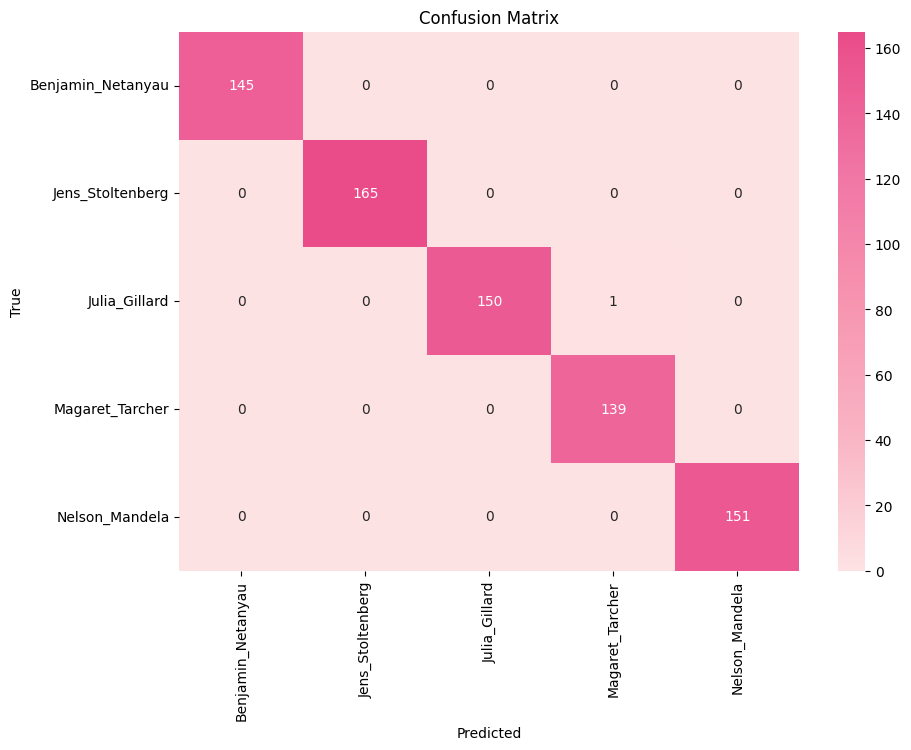

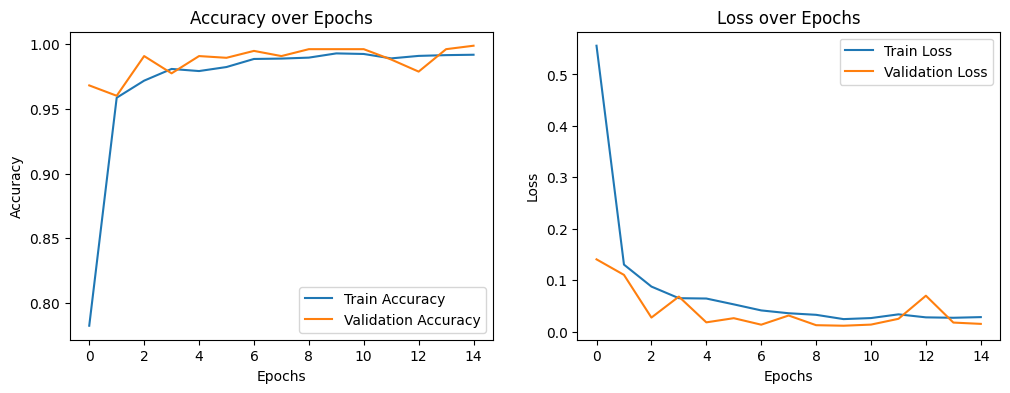

In [ ]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract MFCC features
def extract_mfcc(file_path, n_mfcc=40, max_frames=100):
    try:
        y, sr = librosa.load(file_path, sr=None)  # Load the audio file
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # Extract MFCC features
        
        # Pad or truncate to fixed length
        if mfcc.shape[1] < max_frames:
            pad_width = max_frames - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_frames]  # Truncate if too long
        
        mfcc = np.expand_dims(mfcc, axis=-1)  # Add channel dimension for CNN
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


# Function to load dataset
def load_dataset(dataset_path):
    X = []  # Feature list
    y = []  # Target variable (classification labels)
    label_map = {}  # Map speaker folders to numerical labels
    current_label = 0

    # Iterate through each speaker's folder
    for speaker_folder in os.listdir(dataset_path):
        speaker_path = os.path.join(dataset_path, speaker_folder)

        if os.path.isdir(speaker_path) and speaker_folder != "_background_noise_":  # Exclude background noise
            print(f"Processing speaker: {speaker_folder}")
            label_map[current_label] = speaker_folder  # Map label to speaker name
            
            for file in os.listdir(speaker_path):
                if file.endswith('.wav'):  # Process only .wav files
                    file_path = os.path.join(speaker_path, file)
                    mfcc_features = extract_mfcc(file_path)  # Extract MFCC features
                    if mfcc_features is not None:
                        X.append(mfcc_features)
                        y.append(current_label)  # Assign label to the speaker
            
            current_label += 1

    # Filter out invalid entries
    valid_entries = [(features, label) for features, label in zip(X, y) if features is not None]
    if valid_entries:
        X, y = zip(*valid_entries)
        X = np.array(X)
        y = np.array(y)
    else:
        X, y = np.array([]), np.array([])

    return X, y, label_map


# Main function
def main():
    dataset_path = r"c:/Users/shrav/archive/16000_pcm_speeches"  # Update with your dataset path
    
    # Load dataset and extract features
    print("Loading dataset and extracting MFCC features...")
    X, y, label_map = load_dataset(dataset_path)
    
    if len(X) == 0 or len(y) == 0:
        print("No valid audio data found. Please check the dataset path and structure.")
        return

    # Normalize per sample and reshape data for CNN
    X = np.array([mfcc / np.max(mfcc) for mfcc in X])  # Normalize features per sample
    
    # Split data into 90% training and 10% holdout sets
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)

    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes=len(label_map))
    y_holdout = to_categorical(y_holdout, num_classes=len(label_map))

    # Define CNN model
    print("Building CNN model...")
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(y_train.shape[1], activation='softmax')  
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    print("Training the CNN model...")
    history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_holdout, y_holdout))

    # Evaluate the model on the holdout set
    print("Evaluating the CNN model...")
    y_pred = model.predict(X_holdout)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_holdout, axis=1)

    # Classification report
    print("Classification Report:")
    # Filter label_map to include only used labels
    used_labels = np.unique(y_true_labels)
    filtered_label_map = {label: label_map[label] for label in used_labels}
    print(classification_report(
    y_true_labels, 
    y_pred_labels, 
    target_names=[filtered_label_map[label] for label in used_labels]
    ))
    from matplotlib.colors import LinearSegmentedColormap
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    colors = ["#fde2e4", "#f9b4c4", "#f794b0", "#f074a4", "#ea4c89"]  
    custom_cmap = LinearSegmentedColormap.from_list("custom_pink", colors, N=256)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, xticklabels=[filtered_label_map[label] for label in used_labels],yticklabels=[filtered_label_map[label] for label in used_labels])

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.show()


if __name__ == "__main__":
    main()